# BORA.jl + Turing.jl tutorial: Bayesian BAO inference from 2PCF multipoles

This notebook is a **guided, step-by-step** tutorial showing how to run a standard BAO fit in configuration space using:

- **BORA.jl** as a fast emulator for the BAO template multipoles, and  
- **Turing.jl** to perform **Bayesian inference** (e.g. with NUTS/HMC).

The workflow is designed to feel familiar to **Python users**:
- `using Package` ≈ `import package`
- `Pkg.activate`/`Pkg.instantiate` ≈ creating/using a virtual environment
- `@model ...` in Turing ≈ defining a probabilistic model (like PyMC/NumPyro)

> **Assumptions**
> - You have a set of measured 2PCF multipoles (e.g. from mocks) saved as NumPy `.npy` files.
> - You have a trained BORA emulator folder containing `weights.npy`, `inminmax.npy`, `outminmax.npy` for each multipole ℓ.
> - You want to fit either `(α∥, α⊥)` or the reparameterized `(α_iso, α_AP)`.

---

## 0. Directory layout

You can keep your project like:

```
your_project/
  Project.toml
  Manifest.toml
  data/
    separations_rebin_5_s_0_200.npy
    multipoles_rebin_5_s_0_200.npy
  emulator/
    0/weights.npy  0/inminmax.npy  0/outminmax.npy
    2/weights.npy  2/inminmax.npy  2/outminmax.npy
    4/weights.npy  4/inminmax.npy  4/outminmax.npy
  outputs/
```

If your files are arranged differently, just edit the paths in **Section 2**.

## 1. Julia environment setup

If you are new to Julia:

- `Pkg.activate(".")` activates the environment in the current folder (like `conda activate`).
- `Pkg.instantiate()` installs all packages listed in `Project.toml` / `Manifest.toml`.

If you do **not** have a `Project.toml` yet, you can create one with `Pkg.activate("."); Pkg.add(...)`.


In [1]:
using Pkg
# Activate the environment in this notebook
Pkg.activate(".")

# Install missing deps from Project.toml/Manifest.toml (safe to run multiple times)
# Pkg.instantiate()

  Activating project at `~/Desktop/PhD_project/BAO_euclid/BORA_proj/tutorial`


## 2. Imports

We load the packages used throughout the tutorial.

Notes for Python users:
- `Statistics.mean`, `LinearAlgebra` etc. are part of Julia's standard library.
- `NPZ.jl` reads/writes NumPy `.npy/.npz`.


In [2]:
using Statistics, LinearAlgebra, Random  # Standard libraries
using NPZ                                # To read/write NumPy files .npy/.npz 
using DataInterpolations                 # To perform interpolation of BORA output on the desired separation grid

using Plots                              # Plotting libraries
using StatsPlots

using Distributions                      # Statistics and bayesian inference libraries
using Turing

### BORA.jl

This tutorial assumes **BORA.jl** is available in your environment.

If you are developing BORA locally you might use, e.g.:
```julia
Pkg.develop(path="../BORA.jl") 
```

Otherwise you can install it from GitHub:
```julia
Pkg.add(url="https://github.com/CosmologicalEmulators/Bora.jl.git") 
```

<img src="gorTqd.png"
     style="display: block; margin-left: auto; margin-right: auto;"
     width="200">

In [3]:
using Bora


## 3. Helper utilities used in the pipeline

Below we include some helper functions that have been placed in utility files:
- `utils.jl` --> data loading, covariance corrections, emulator I/O
- `plotting_utils.jl` --> input measurements and best-fit/posterior mean model plotting

In [4]:
include("utils.jl")
include("plotting_utils.jl")

plot_bestfit (generic function with 1 method)

## 4. Load the BORA emulator

BORA emulates the BAO template multipoles (from BAOFit) on a separation grid `s_test`.
We typically use a grid that is:
- broad enough to support interpolation onto the data grid `s`,
- somewhat denser in the BAO region.


In [5]:
using SimpleChains
using Static
using JSON
import JSON.parsefile

#TODO: The following functions will be implemented directly in BORA so users do not need to define them manually. \
The MLP architecture will be read from a `setup.json` file defined during training.

In [6]:
# Load emulators for ℓ=0,2,4 into a "CompleteEmulator"
emul_path   = "/Users/andreacrespi/Desktop/PhD_project/BAO_euclid/BORA_proj/trained_BORA_150000_100points_Sigma_s_5000_256_Dnorm"
ξℓ_emu = Bora.load_complete_emulator(emul_path);

[ Info: 🔄 Loading BORA emulator
[ Info: ✅ Loading completed


## 5. Load data and build the data vector

We define:
- the fitting scale range `[smin, smax]`,
- which multipoles to fit (`ells`),
- and the number of model parameters (needed for covariance corrections like Percival).

The example below has:
- 7 BAO parameters ($\alpha$ parameters, $b$, $f$, $\Sigma$ parameters),
- plus 3 polynomial broadband coefficients per multipole.

In [7]:
# -----------------------
# User configuration
# -----------------------
Random.seed!(42)

# Dataset labels
mock_set = "ELM"       # ELM/FLAGSHIP/TR1/... --> which set of mocks
recon = "rec"      # pre_rec/rec          --> if pre or post reconstruction
mock_type = "correct"  # correct/measured     --> which type of mocks
zbin = "z1"            # z1/z2/z3/z4          --> which redshift bin
mock_id = 0            # 0 or 1-1000          --> mock ID (0 = mean of mocks; >0 uses that mock index)

# Path (EDIT this)
data_path   = "/Users/andreacrespi/Desktop/PhD_project/BAO_euclid/BORA_proj/mocks/$(mock_set)/$(recon)/$(mock_type)/$(zbin)/"

#mkpath(output_path) if the output directory does not already exist

# Fit settings
smin, smax = 50.0, 150.0
ℓ_max = 4

ells = ℓ_max == 4 ? (0,2,4) :
       ℓ_max == 2 ? (0,2)   :
       ℓ_max == 0 ? (0,)    :
       throw(ArgumentError("ℓ_max must be 0, 2, or 4."))

# Parameter count used for covariance corrections
N_params = 7 + 3*length(ells)

16

In [8]:
# Load the measurement vector + covariance
s, flat_data, covariance = LoadData2(data_path, smin, smax, N_params; ells=ells, mock_id=mock_id, correct="hartlap");

[ Info: 🔄 Loading data 🔄


Using the mean of 1000 mocks.

[ Info: ✂️ Separation range cutting ✂️
[ Info: 🧮 Covariance and Percival correction 🧮
[ Info: ✅ Loading completed


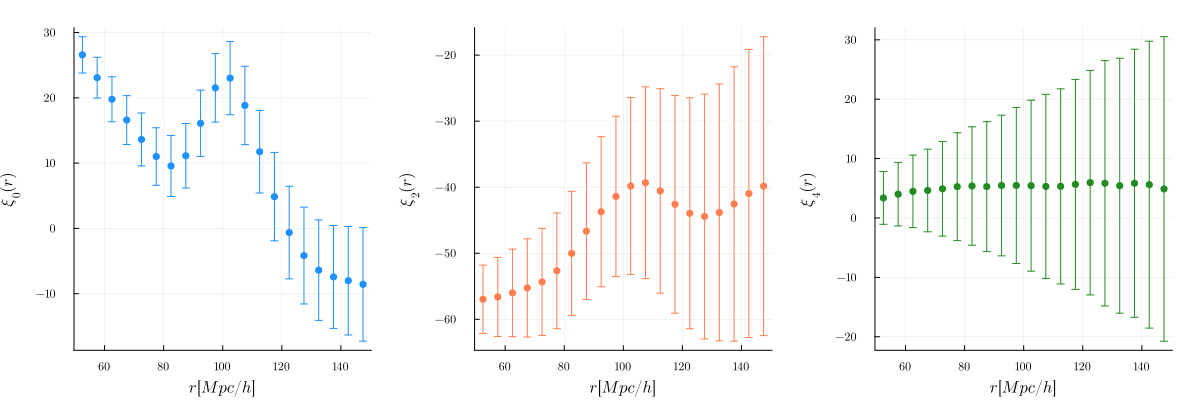

In [9]:
plot_measurements(s, flat_data, covariance; ells=ells, save_fn = nothing)

## 6. Whitening the data (recommended)

For numerical stability in MCMC, it is often convenient to **whiten** the data using the covariance:

- Let `Γ = sqrt(C)` such that `C = Γ Γᵀ` (matrix square root)
- Define `D = Γ⁻¹ d` and compare to `Γ⁻¹ m(θ)`

This is equivalent to the usual Gaussian likelihood but is usually more stable.

In [10]:
Γ = sqrt(covariance)
inv_Γ = inv(Γ)
D = inv_Γ*flat_data;

## 7. Define the Turing model

Inference model:

- Parameters:
  - BAO scaling parameters as `(α_ISO, α_AP)` (internally mapped to `α∥, α⊥`), or directly `(α∥, α⊥)`
  - bias `b`, growth `f`
  - damping scales `Σ`’s
  - polynomial broadband terms for each multipole

- Likelihood:
  - Gaussian in the whitened space: `D ~ Normal(inv_Γ * model(θ), I)`

This matches the standard `χ²` likelihood.

In [11]:
ℓ_to_ℓidx = Dict(0=>1, 2=>2, 4=>3)

@model function polyBB_BORAmodel(D, inv_Γ, emu, s, zbin, growth; ells=(0, 2, 4), iso_ap=false)

    ℓidx = getindex.(Ref(ℓ_to_ℓidx), collect(ells))

    # --- Priors ---
    # Some parameters are rescaled to ensure a small condition number of the Gaussian posterior.
    
    if iso_ap
        α̃ISO ~ 100*Uniform(0.8, 1.2)
        α̃AP ~ 100*Uniform(0.8, 1.2)
        αpar = (α̃ISO/100) * (α̃AP/100)^(2/3)
        αperp = (α̃ISO/100) * (α̃AP/100)^(-1/3)
    else
        α̃par ~ 100*Uniform(0.8, 1.2)
        α̃perp ~ 100*Uniform(0.8, 1.2)
        αpar = α̃par/100
        αperp = α̃perp/100
    end
    b̃ ~ 10*Uniform(0., 5.)  
    f̃ ~ 10*Uniform(0., 2.)
    Σpar ~ Uniform(0., 20.)
    Σperp ~ Uniform(0., 20.)
    Σs ~ Uniform(0., 10.)

    lim = 20

    B00 ~ Uniform(-lim, lim)
    B01 ~ Uniform(-lim, lim)
    B02 ~ Uniform(-lim, lim)
    
    B20 = 0.0; B21 = 0.0; B22 = 0.0
    if 2 in ells
        B20 ~ Uniform(-lim, lim)
        B21 ~ Uniform(-lim, lim)
        B22 ~ Uniform(-lim, lim)
    end
    
    B40 = 0.0; B41 = 0.0; B42 = 0.0
    if 4 in ells
        B40 ~ Uniform(-lim, lim)
        B41 ~ Uniform(-lim, lim)
        B42 ~ Uniform(-lim, lim)
    end

    bao_params = [αpar, αperp, b̃/10, f̃/10, Σpar, Σperp, Σs, get_zeff(zbin)]
    bb_params = [B00, B01, B02, B20, B21, B22, B40, B41, B42]

    # --- Build model prediction ---
    # Emulator provides multipoles on s_test
    theory = Bora.get_ξℓs(bao_params, emu)

    # Broadband evaluated on the data s grid. 
    # For now, Bora provides the polynomial broadband only.
    # The spline broadband has been already implemented but it needs to be validated and included in the official repository.
    BB = Bora.get_broadband(s, bb_params)

    # Interpolate emulator prediction to s and add broadband
    s_test = emu.rgrid
    ξ_list = [(growth^2) .* DataInterpolations.AkimaInterpolation(view(theory, idx, :), s_test).(s) .+ view(BB, idx, :) for idx in ℓidx]
    interp_ξ = permutedims(hcat(ξ_list...))
    
    flattheory = reshape((interp_ξ)', (size(inv_Γ)[1],))
    
    # Whitened model vector
    prediction = (inv_Γ * flattheory)

    # --- Likelihood ---
    D ~ MvNormal(prediction, I)
    
    return nothing
end

polyBB_BORAmodel (generic function with 2 methods)

## 8. Analysis example

We now run an example analysis, computing best-fit parameters using either the *MAP* or *MLE* (via minimization), and then running an *MCMC chain*.

### 8.1 Growth factor from BackgroundCosmology Extension

Before starting, we note that, since redshift is a free parameter of the emulation, the multipoles are rescaled by $D^2(z)$, the linear growth factor in the fiducial cosmology, which encodes most of the redshift dependence. This reduces the dynamic range of the training targets and improves training efficiency without significantly increasing the number of required training samples. `BORA`’s predictions are then multiplied by the same factor to recover the physical multipoles.

In [12]:
# The BackgroundCosmology extension is already included in the AbstractCosmologicalEmulators package and is activated by importing 
#     its dependencies.

using AbstractCosmologicalEmulators
using OrdinaryDiffEqTsit5
using SciMLSensitivity
using Integrals
using DataInterpolations
using LinearAlgebra
using FastGaussQuadrature
using ForwardDiff
using Zygote

const ext = Base.get_extension(AbstractCosmologicalEmulators, :BackgroundCosmologyExt)
if !isnothing(ext)
    using .ext: D_z
end

In [13]:
# Growth factor for the ELM fiducial cosmology: Ωₘ=0.32, h=0.67, mν=0., w₀=-1., wₐ=0.
growth = ext.D_z(get_zeff(zbin), 0.32, 0.67; mν=0., w0=-1, wa=0)

0.47251968923103316

### 8.2 Instantiation of the posterior model and initial parameter values.

In [14]:
posterior_model = polyBB_BORAmodel(D, inv_Γ, ξℓ_emu, s, zbin, growth, ells=ells, iso_ap=true);

In [15]:
initial_bao_params = rand(MvNormal([100, 100, 15, 1, 5, 5, 5], 0.5*I))
initial_bb_params = rand(Normal(0, 1), 3*length(ells))
initial_params = vcat(initial_bao_params, initial_bb_params);

### 8.3 Run MAP / MLE

The posterior model is entirely ***Automatic Differentiable*** (including `BORA.jl`), so we can leverage optimized, gradient-based minimizers such as L-BFGS (default for `Turing.jl`).

In [16]:
BF_MAP = maximum_a_posteriori(posterior_model; initial_params=initial_params)
BF_MLE = maximum_likelihood(posterior_model; initial_params=initial_params);

In [17]:
print("Minimization convergence: ", BF_MAP.optim_result.retcode, "\n")
print("Minimization result: ",BF_MAP.values)

Minimization convergence: Success
Minimization result: [100.20035902568381, 99.85893774326063, 16.5779441510293, 9.130793282317395, 6.498559522874445, 2.889642282445065, 1.878016325449505, -0.16824632327641353, 0.5566058249341701, -0.25139597807687863, 0.06288898300243773, -0.20932110330373987, 0.6959965090736233, -0.2279983801043386, 0.6802134413611114, -0.524030800650376]

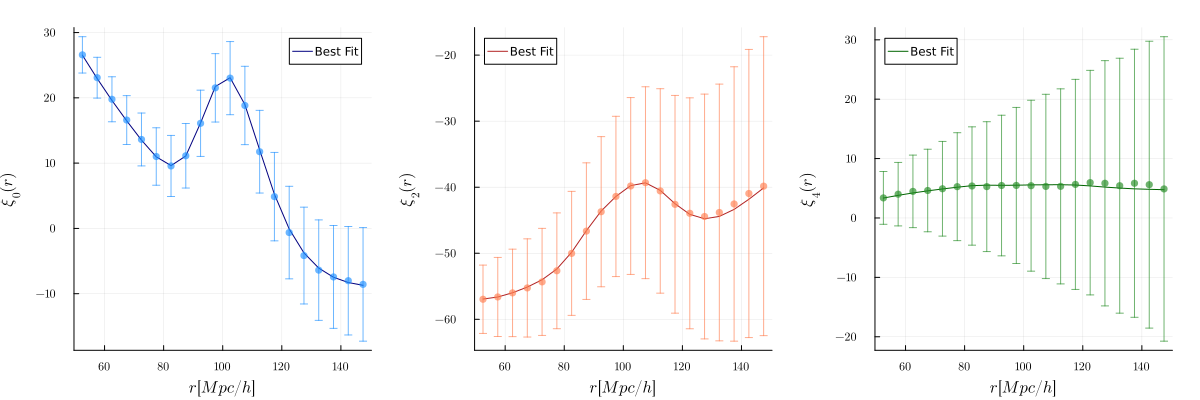

In [18]:
# Best-fit visualization.

BF = BF_MLE.values.array

ℓidx = getindex.(Ref(ℓ_to_ℓidx), collect(ells))

iso_ap=true
αpar = (BF[1]/100) * (BF[2]/100)^(2/3)
αperp = (BF[1]/100) * (BF[2]/100)^(-1/3)
bao_params = [αpar, αperp, BF[3]/10, BF[4]/10, BF[5], BF[6], BF[7], get_zeff(zbin)]

bb_params = vcat(BF[8:end], zeros(3*(3-length(ells))))

theory = Bora.get_ξℓs(bao_params, ξℓ_emu)
BB = Bora.get_broadband(s, bb_params)

s_test = ξℓ_emu.rgrid
ξ_list = [(growth^2) .* DataInterpolations.AkimaInterpolation(view(theory, idx, :), s_test).(s) .+ view(BB, idx, :) for idx in ℓidx]
interp_ξ = permutedims(hcat(ξ_list...))

best_fit = interp_ξ

plot_bestfit(s, flat_data, covariance, best_fit; ells=ells, save_fn = nothing)

In [19]:
# Goodness-of-fit: χ²
model_flat = reduce(vcat, [best_fit[i, :] for i in 1:size(best_fit, 1)])
chi2, chi2red = chisq(flat_data, model_flat, Matrix(covariance); nparams=N_params)
@info "chi2 = $chi2, chi2/dof = $chi2red"

[ Info: chi2 = 0.08294993038216897, chi2/dof = 0.0018852256905038402


### 8.4 Run MCMC chain
For MCMC we use `Turing.NUTS(0.75)` (similar to HMC/NUTS in PyMC/Stan), with 0.75 as target acceptance rate.

- `n_steps`: number of posterior samples per chain
- `n_adapts`: warm-up / adaptation steps
- `n_chains`: number of parallel chains (use threads)

In [20]:
# MCMC settings
n_chains = 2
n_steps  = 1_000

# Sampler
nuts = Turing.NUTS(0.75)

# Tip: enable multithreading by starting Julia with JULIA_NUM_THREADS=8
n_threads = Threads.nthreads()
@info "Number of available threads" n_threads

┌ Info: Number of available threads
└   n_threads = 10


In [21]:
chains = sample(posterior_model, nuts, MCMCThreads(), n_steps, n_chains; progress=true, dialog=true)

┌ Info: Found initial step size
└   ϵ = 0.025
┌ Info: Found initial step size
└   ϵ = 0.025
Sampling (2 threads): 100%|█████████████████████████████| Time: 0:02:25


Chains MCMC chain (1000×30×2 Array{Float64, 3}):

Iterations        = 501:1:1500
Number of chains  = 2
Samples per chain = 1000
Wall duration     = 174.89 seconds
Compute duration  = 343.72 seconds
parameters        = α̃ISO, α̃AP, b̃, f̃, Σpar, Σperp, Σs, B00, B01, B02, B20, B21, B22, B40, B41, B42
internals         = n_steps, is_accept, acceptance_rate, log_density, hamiltonian_energy, hamiltonian_energy_error, max_hamiltonian_energy_error, tree_depth, numerical_error, step_size, nom_step_size, lp, logprior, loglikelihood

Use `describe(chains)` for summary statistics and quantiles.


We compute now:

- summary statistics (mean/std, ESS, R-hat)
- quantiles

In [22]:
#using MCMCChains

summ = summarystats(chains)
display(summ[:, [:mean, :std, :ess_bulk, :rhat]])

Summary Statistics

  parameters       mean       std    ess_bulk      rhat 
      Symbol    Float64   Float64     Float64   Float64 

        α̃ISO   100.3480    1.5579   1998.8779    1.0022
         α̃AP   100.4558    5.3965   1646.6770    1.0005
           b̃    17.4707    2.7049   1090.3416    1.0014
           f̃     9.7857    5.3432   1105.0313    0.9998
        Σpar     6.4520    4.1737   1278.6694    1.0015
       Σperp     4.2847    2.8919   1233.3247    1.0092
          Σs     4.3706    2.5997   1530.3293    1.0028
         B00    -0.4775    1.4230    813.9974    1.0009
         B01     1.8112    3.5284    741.7080    1.0009
         B02    -1.3976    2.3644    727.4954    1.0019
         B20    -0.7361    3.1623    994.9198    1.0006
         B21     1.8749    7.1617    965.6372    1.0005
         B22     0.1794    5.9608   1052.2933    1.0007
         B40     0.1772    3.3770    966.9315    1.0020
         B41    -0.5221    7.2496    914.6526    1.0013
         B42     0.20

In [23]:
qs = quantile(chains, q=[0.1587, 0.5, 0.8413])
display(qs)

Quantiles

  parameters   15.870000000000001%      50.0%   84.13000000000001% 
      Symbol               Float64    Float64              Float64 

        α̃ISO               98.8322   100.3118             101.8270
         α̃AP               95.1107   100.3982             105.6176
           b̃               14.9749    17.2492              20.0459
           f̃                3.6164     9.7746              15.9952
        Σpar                2.0634     6.0152              10.6654
       Σperp                1.3062     3.9105               7.1789
          Σs                1.3573     4.3325               7.2673
         B00               -1.8607    -0.4803               0.9306
         B01               -1.6196     1.7879               5.1946
         B02               -3.5339    -1.2279               0.8198
         B20               -3.9293    -0.7784               2.3649
         B21               -5.3976     1.8447               9.0983
         B22               -5.7617    -0.324

### 8.5 Saving results

We save:
- raw cha"in array (NumPy `.npy`) to use Python plotting libraries, such as GetDist
- summary stats and quantiles

You can load the saved arrays in Python with `numpy.load(...)`.

In [24]:
# Save stack chains to NumPy
output_path = "/Users/andreacrespi/Desktop/PhD_project/BAO_euclid/BORA_proj/tutorial/"

chain_array = reduce(vcat, [chains.value.data[:, :, i] for i in 1:n_chains])
npzwrite(joinpath(output_path, "bao_polyBB_chains.npy"), chain_array)

diagnostics = summ[:, [:mean, :std, :ess_bulk, :rhat]][:, :]
quantiles = qs[:, :]
npzwrite(joinpath(output_path, "bao_polyBB_sumstats.npy"), Matrix{Float64}(diagnostics))
npzwrite(joinpath(output_path, "bao_polyBB_quantiles.npy"), Matrix{Float64}(quantiles))